# Loading and visualizing results ([open in colab](https://colab.research.google.com/github/openai/baselines/blob/master/docs/viz/viz.ipynb))
In order to compare performance of algorithms, we often would like to visualize learning curves (reward as a function of time steps), or some other auxiliary information about learning aggregated into a plot. Baselines repo provides tools for doing so in several different ways, depending on the goal.

## Preliminaries / TensorBoard
First, let us install baselines repo from github

In [6]:
%pip install git+https://github.com/openai/baselines

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/openai/baselines to /tmp/pip-req-build-hogwat_b
  Running command git clone --filter=blob:none --quiet https://github.com/openai/baselines /tmp/pip-req-build-hogwat_b
  Resolved https://github.com/openai/baselines to commit ea25b9e8b234e6ee1bca43083f8f3cf974143998
  Preparing metadata (setup.py) ... done
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


For all algorithms in baselines summary data is saved into a folder defined by logger. By default, a folder $TMPDIR/openai-<date>-<time> is used; you can see the location of logger directory at the beginning of the training in the message like this:

Logging to /var/folders/mq/tgrn7bs17s1fnhlwt314b2fm0000gn/T/openai-2018-10-29-15-03-13-537078
The location can be changed by changing OPENAI_LOGDIR environment variable. For instance, 

In [7]:
!OPENAI_LOGDIR=$HOME/logs/cartpole-ppo OPENAI_LOG_FORMAT=csv python -m baselines.run --alg=ppo2 --env=CartPole-v0 --num_timesteps=30000 --nsteps=128

2022-06-03 13:55:06.806569: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-03 13:55:06.806603: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/local/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/vscode/.local/lib/python3.10/site-packages/baselines/run.py", line 12, in <module>
    from baselines.common.cmd_util import common_arg_parser, parse_unknown_args, make_vec_env, make_env
  File "/home/vscode/.local/lib/python3.10/site-packages/baselines/common/cmd_util.py", line 16, in <module>
    from baselines.common.atari_wrappers import

Notice also the usage of `OPENAI_LOG_FORMAT` environment variable - this allows us to suppress printing to stdout. 
Permissible values for `OPENAI_LOG_FORMAT` environment variables are `stdout`, `log`, `csv`, and `tensorboard` (multiple values can be comma-separated). 
The latter one (`tensorboard`) dumps values in tensorboard format, which allows for their viewing in [TensorBoard](https://www.tensorflow.org/guide/summaries_and_tensorboard). TensorBoard provides nice visualization and in many cases is the easiest way to look at the summary of the results. However, if tensorboard visualization is not sufficient, read on...


## Loading results and plotting using matplotlib
Bаselines provides helper functions to load the summaries of the results as pandas dataframes. 
For instance, the following:

In [8]:
from baselines.common import plot_util as pu
results = pu.load_results('~/logs/cartpole-ppo') 

ModuleNotFoundError: No module named 'pandas'

will search for all folders with baselines-compatible results in ~/logs/cartpole-ppo and subfolders and return a list of `Result` objects. Each `Result` object is a named tuple with the following fields:

  * dirname: str - name of the folder from which data was loaded
  
  * metadata: dict) - dictionary with various metadata (read from metadata.json file)

  * progress: pandas.DataFrame - tabular data saved by logger as a pandas dataframe. Available if csv is in logger formats.

  * monitor: pandas.DataFrame - raw episode data (length, episode reward, timestamp). Available if environment wrapped with Monitor wrapper
  
Thus, a learning curve from a single run can be plotted as follows (note the cumulative sum trick to get convert lengths of the episodes into number of time steps taken so far)
 

In [4]:
import matplotlib.pyplot as plt
import numpy as np
r = results[0]
plt.plot(np.cumsum(r.monitor.l), r.monitor.r)

NameError: name 'results' is not defined

The raw learning curve from a single run can be very noisy. To smoothen it and analyze if any learning actually takes place, we can use `plot_util.smooth()` function:

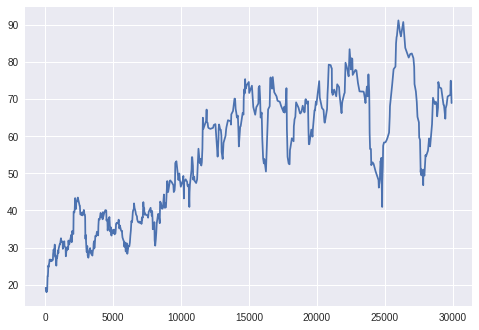

In [22]:
plt.plot(np.cumsum(r.monitor.l), pu.smooth(r.monitor.r, radius=10))

Similar curve can be obtained by using logger summaries (instead of raw episode data in monitor.csv):


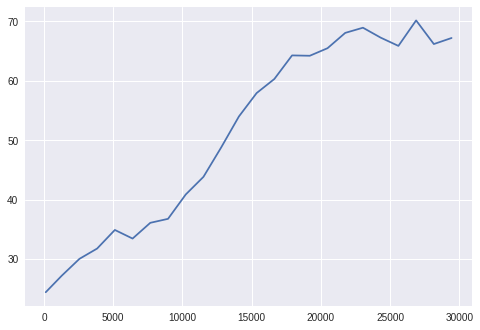

In [23]:
plt.plot(r.progress.total_timesteps, r.progress.eprewmean)

Note, however, that raw episode data is stored by the Monitor wrapper, and hence looks similar for all algorithms, whereas progress data is handled by the algorithm itself, and hence can vary (column names, type of data available) between algorithms.

## Plotting: many curves
While the loading and plotting functions described above in principle give you access to any slice of the training summaries, sometimes it is necessary to plot and compare many training runs (multiple algorithms, multiple seeds for random number generator), and usage of the functions above can get tedious and messy. For that case, `baselines.common.plot_util` provides convenience function plot_results that handles multiple `Result` objects that need to be routed in multiple plots. Consider the following bash snippet that runs ppo2 with cartpole with 6 different seeds for 30k time steps, first with rollout batch size 32, and then with batch size 128 (note that the next cell will take a little while to run):

In [24]:
!for seed in $(seq 0 5); do OPENAI_LOG_FORMAT=csv OPENAI_LOGDIR=$HOME/logs/cartpole-ppo-hp/b32-$seed python -m baselines.run --alg=ppo2 --env=CartPole-v0 --num_timesteps=3e4 --seed=$seed --nsteps=32; done
!for seed in $(seq 0 5); do OPENAI_LOG_FORMAT=csv OPENAI_LOGDIR=$HOME/logs/cartpole-ppo-hp/b128-$seed python -m baselines.run --alg=ppo2 --env=CartPole-v0 --num_timesteps=3e4 --seed=$seed --nsteps=128; done

env_type: classic_control
Training ppo2 on classic_control:CartPole-v0 with arguments 
{'nsteps': 32, 'network': 'mlp'}
env_type: classic_control
Training ppo2 on classic_control:CartPole-v0 with arguments 
{'nsteps': 32, 'network': 'mlp'}
env_type: classic_control
Training ppo2 on classic_control:CartPole-v0 with arguments 
{'nsteps': 32, 'network': 'mlp'}
env_type: classic_control
Training ppo2 on classic_control:CartPole-v0 with arguments 
{'nsteps': 32, 'network': 'mlp'}
env_type: classic_control
Training ppo2 on classic_control:CartPole-v0 with arguments 
{'nsteps': 32, 'network': 'mlp'}
env_type: classic_control
Training ppo2 on classic_control:CartPole-v0 with arguments 
{'nsteps': 32, 'network': 'mlp'}
env_type: classic_control
Training ppo2 on classic_control:CartPole-v0 with arguments 
{'nsteps': 128, 'network': 'mlp'}
env_type: classic_control
Training ppo2 on classic_control:CartPole-v0 with arguments 
{'nsteps': 128, 'network': 'mlp'}
env_type: classic_control
Training ppo

The results of 12 runs from the cell above can be loaded just as before, via (we discard first result that is actually from the very first run in the previous section):

In [25]:
results = pu.load_results('~/logs/cartpole-ppo-hp'); print(len(results))

12


/usr/local/lib/python3.6/dist-packages/baselines/bench/monitor.py:164: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.headers = headers # HACK to preserve backwards compatibility


But how do we plot all 12 of them in a sensible manner? `baselines.common.plot_util` module provides plot_results function to do just that:

(<matplotlib.figure.Figure at 0x7f4d4bc1bc88>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4d4bad9358>],
       dtype=object))

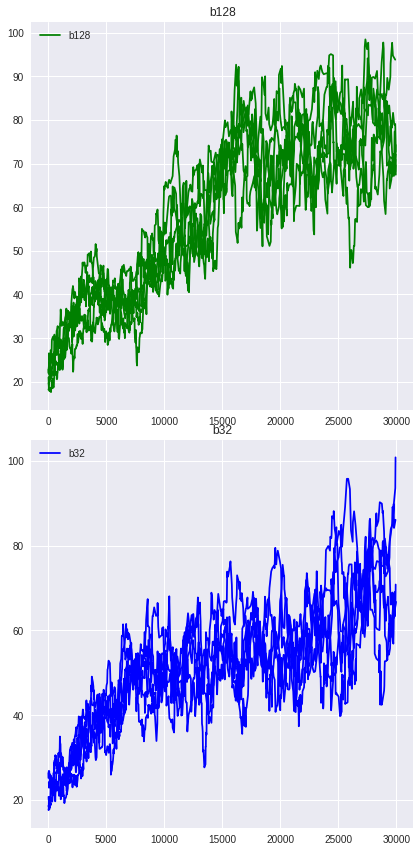

In [26]:
pu.plot_results(results)

The results are split into two groups based on batch size and are plotted on a separate graph. More specifically, by default plot_results considers digits after dash at the end of the directory name to be seed id and groups the runs that differ only by those together.

Showing all seeds on the same plot may be somewhat hard to comprehend and analyse. We can instead average over all seeds via the following command:

(<matplotlib.figure.Figure at 0x7f4d4bcd8240>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4d4b9f55c0>],
       dtype=object))

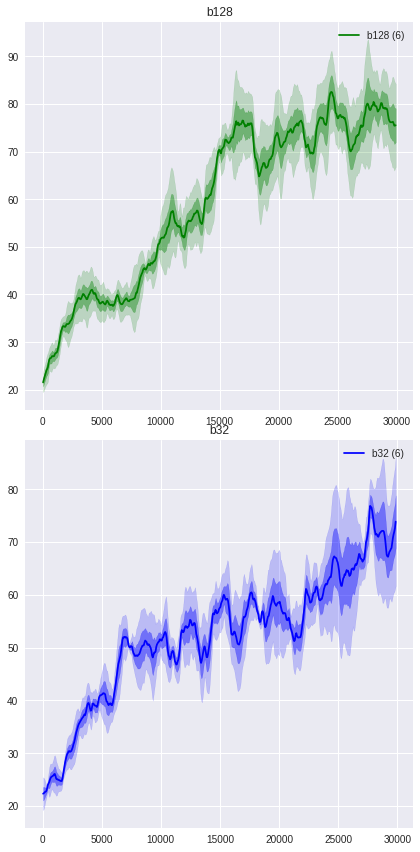

In [27]:
pu.plot_results(results, average_group=True)

The lighter shade shows the standard deviation of data, and darker shade - error in estimate of the mean (that is, standard deviation divided by square root of number of seeds). Note that averaging over seeds requires resampling to a common grid, which, in turn, requires smoothing (using language of signal processing, we need to do low-pass filtering before resampling to avoid aliasing effects). You can change the amount of smoothing by adjusting `resample` and `smooth_step` arguments to achieve desired smoothing effect See the docstring of plot_util function for more info.

To plot both groups on the same graph, we can use the following:

(<matplotlib.figure.Figure at 0x7f4d4b919cc0>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4d4b95f198>]],
       dtype=object))

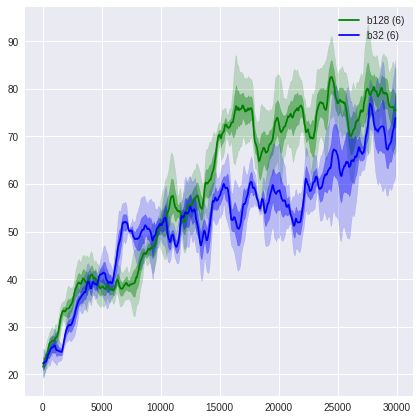

In [28]:
pu.plot_results(results, average_group=True, split_fn=lambda _: '')

Option `split_fn=labmda _:''` effectively disables splitting, so that all curves end up on the same panel.

Now, with many groups the overlapping shaded regions may start looking messy. We can disable either light shaded region (corresponding to standard deviation of the curves in the group) or darker shaded region (corresponding to the error in mean estimate) by using `shaded_std=False` or `shaded_err=False` options respectively. For instance,

(<matplotlib.figure.Figure at 0x7f4d4b8577b8>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4d4b8bc4e0>]],
       dtype=object))

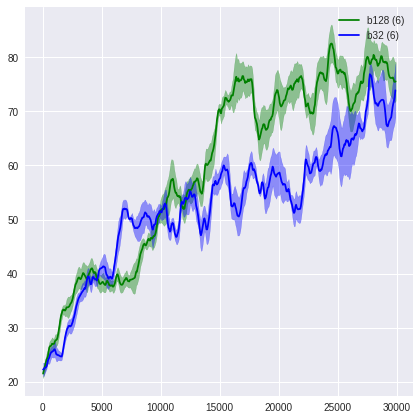

In [29]:
pu.plot_results(results, average_group=True, split_fn=lambda _: '', shaded_std=False)